In [1]:
# We always start with appropriate imports; note the use of the IPython magic
# command to set up Matplotlib within the notebook
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fft
from scipy.fftpack import fftshift, ifftshift
import cmath
import pylab

In [2]:
import numpy.fft as fft
import scipy.ndimage as nd
import scipy.misc as misc
from math import pi

In [3]:
def beam(E):
    """This is a function of the X-ray beam
    input: E, energy
    output: wavelength; k, wave number"""
    
    h=6.62607004*10**(-34)
    c=3*10**8
    ev=1.6*10**(-19)
    Wavelength= (h*c)/(E*ev)
    k=2*np.pi/Wavelength
    #x=np.arange(0,101)
    #wave=np.exp(1j*k*x)
    return k

In [4]:
def sample_data(N):
    """Information for the testing sample, and the particles are located in the centre
    input: 
    N, particles number along a side
    L, length of the sample
    output: """
    n=int(N/2)
    L=N
    a=np.ones((N,N))
    sample = np.pad(a, ((N,N) , (N,N)), mode = 'constant', constant_values=(1e-16, 1e-16))
    return sample
    

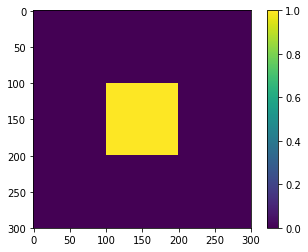

In [5]:
sample=sample_data(100)
plt.imshow(sample)
plt.colorbar()
plt.show()

In [7]:
def gamma(N,sigma_x_t,sigma_y_t,L1,E):
    """
    input:
    """

    
    k=beam(E)
    xi_x = L1/(k*sigma_x_t)
    xi_y = L1/(k*sigma_y_t)
    xi_x_sq = xi_x*xi_x
    xi_y_sq = xi_y*xi_y
    
    L=N
    L_real=(1e-10)*L
    L_center=3*L_real/2
    x1 = np.linspace(-L_center,L_center,3*N)
    y1 = np.linspace(-L_center,L_center,3*N)
    a1,b1 = np.meshgrid(x1,y1,indexing='ij')
    cdc = np.exp(-a1**2/(2*xi_x_sq )-b1**2/(2*xi_y_sq))
    #plt.imshow(cdc,extent=[0,4*L_real,0,4*L_real])
    #plt.show()
    return cdc

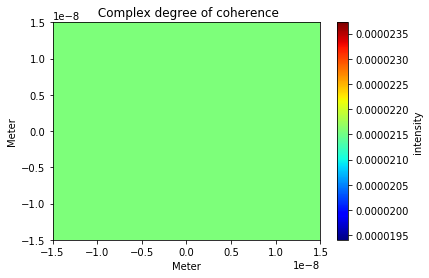

In [16]:
N=100
L=N
L_real=(1e-10)*L
L_center=3*L_real/2
x1 = np.linspace(-L_center,L_center,3*N)
y1 = np.linspace(-L_center,L_center,3*N)

cdc=gamma(100,4e-10,4e-10,150,8000)
"""plt.imshow(cdc)
plt.colorbar()
plt.show()"""
plt.title(' Complex degree of coherence')
plt.xlabel('Meter')
plt.ylabel('Meter')
pylab.pcolor(x1,y1,cdc,cmap='jet')
pylab.colorbar(label='intensity')
plt.show()

In [9]:
def TAF(N,source_z,xi_l):
    """The time autocorrelation function
    input: 
    source_z, longitudinal coherent wavelengths difference"""
    x2 = np.linspace(-source_z,source_z,n)
    a2,a2 = np.meshgrid(x2,x2,indexing='ij')
    # the time autocorrelation function
    f = np.exp(-np.sqrt(a2**2+a2**2)/xi_l)
    return f

In [10]:
from numpy.fft import fft, ifft, fft2, ifft2, fftshift

def fft_convolve2d(x,y):
    """ 2D convolution, using FFT"""
    fr = fft2(x)
    fr2 = fft2(np.flipud(np.fliplr(y)))
    m,n = fr.shape
    cc = np.real(ifft2(fr*fr2))
    cc = np.roll(cc, -int(m/2)+1,axis=0)
    cc = np.roll(cc, -int(n/2)+1,axis=1)
    return cc

In [11]:
def phase_retrieval(N,sigma_x_t,sigma_y_t,L1,E,iters):
    """
    input:
    """
    beta=0.9
    L=N
    mid=int(3*N/2)
    sample=sample_data(N)
    p=int(N*N)
    plt.title('2D sample diagram with %i pixels'%p)
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')
    pylab.pcolor(sample.real,cmap='jet')
    pylab.colorbar(label='Density')
    plt.show()
    #fourier transform of the density of the particles
    dg_FFT = np.fft.fftn(fftshift(sample)) #side
    dg_FFT_centre = fftshift(dg_FFT) #centre
    amplitude_c=abs(dg_FFT_centre) #centre
    amplitude_c_s=abs(dg_FFT) #side
    intensity_c=abs(dg_FFT_centre*np.conj(dg_FFT_centre)) #centre
    ###############################################################################
    
    #X-ray information
    cdc=gamma(N,sigma_x_t,sigma_y_t,L1,E)# cdc = complex degree of coherence #centre
    f=1 #f = time autocorrelation function
    maf=np.fft.fftn(fftshift(cdc)) #mutual autocorrelation function side
    maf_shift=fftshift(maf) #centre

    # diffraction pattern of incoherence X-ray
    intensity=fft_convolve2d(amplitude_c_s**2,maf)#centre
    amplitude=fftshift(np.sqrt(abs(intensity))) #normalised amplitude on the side
    
    #################################################################################
    
    plt.title('Initial intensity pattern')
    plt.xlabel('$Pixels^{-1}$')
    plt.ylabel('$Pixels^{-1}$')
    pylab.pcolor(intensity_c[mid-10:mid+10,mid-10:mid+10], cmap='jet')
    pylab.colorbar(label='Intensity')
    plt.show()
    
    psi_degree=np.random.randint(0,360,size=(3*N,3*N)) 
    psi_pi=2*pi*psi_degree/360
    plt.title('Initial phase diagram')
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')
    pylab.pcolor(psi_pi,cmap='jet') 
    pylab.colorbar(label='Phase')
    plt.show()
    
    sample_original=fft_convolve2d(sample,cdc)
    plt.imshow(sample_original)
    plt.colorbar()
    plt.show()
    
    #sample1 = np.abs(np.real(fftshift(np.fft.ifftn(amplitude*np.exp(1j*psi_pi)))))
    sample1 = np.abs(np.real(fftshift(np.fft.ifftn(amplitude))))
    sample1[0:L,0:3*L]=1e-16
    sample1[2*L:3*L,0:3*L]=1e-16
    sample1[L:2*L,0:L]=1e-16
    sample1[L:2*L,2*L:3*L]=1e-16

    
    nbig=0 
    #chi_s_list=[]
    chi_s_list=[]
    chi_d_list=[1]
    n1=1
    nbig=0
    
    while nbig <= iters:
        
        nn=0    
        while nn < 4 and chi_d_list[n1-1]>=1e-6:
            sample2=sample1
            pattern_wrong=np.fft.fftn(fftshift(sample1)) 
            pattern_phase=np.angle(pattern_wrong)
            pattern_true=amplitude*np.exp(1j*pattern_phase)
            sample1 = np.abs(np.real(fftshift(np.fft.ifftn(pattern_true))))
            sample[0:L,0:3*L]=1e-16
            sample[2*L:3*L,0:3*L]=1e-16
            sample[L:2*L,0:L]=1e-16
            sample[L:2*L,2*L:3*L]=1e-16
            sample3=sample1
        
            delta_s = sample1 - sample
            intensity_wrong=(abs(pattern_wrong))**2
            delta_d = amplitude**2-intensity_wrong
            #the chi square of the sample and diffraction pattern
            chi_sq_s = np.sum(np.abs(delta_s))/np.sum(sample)
            chi_sq_d = np.sum(np.abs(delta_d))/np.sum(amplitude**2) 
            chi_s_list.append(chi_sq_s)
            chi_d_list.append(chi_sq_d)
            
            nn+=1 
            n1+=1
        
        plt.title('Intensity pattern after %i iterations'%n1)
        plt.xlabel('$Pixels^{-1}$')
        plt.ylabel('$Pixels^{-1}$')
        pylab.pcolor(intensity[mid-10:mid+10,mid-10:mid+10], cmap='jet')
        pylab.pcolor(intensity[mid-10:mid+10,mid-10:mid+10], cmap='jet')
        pylab.colorbar(label='Intensity')
        #plt.colorbar(label='Intensity')
        plt.show()

        plt.title('Retrieved phase after %i iterations'%n1)
        plt.xlabel('Pixels')
        plt.ylabel('Pixels')
        pylab.pcolor(pattern_phase,cmap='jet') 
        pylab.colorbar(label='Phase')
        plt.show()

        plt.title('Retrieved 2D sample diagram after %i iterations'%n1)
        plt.xlabel('Pixels')
        plt.ylabel('Pixels')
        pylab.pcolor(sample1.real,cmap='jet')
        pylab.colorbar(label='Density')
        plt.show()    
        n=0
        while n < 4 and chi_d_list[n1-1]>=1e-6:
            sample4 = np.zeros((3*L,3*L))
            for i in range (0,3*L):
                for j in range (0,3*L):
                    if L <= i <= 2*L and L <= j <= 2*L:
                        sample4[i,j] = np.abs(np.real(sample3[i,j]))
                    else:
                        sample4[i,j] = np.abs(np.real(sample2[i,j] - sample3[i,j]*beta))
                        
            pattern_wrong=np.fft.fftn(fftshift(sample4)) 
            pattern_phase=np.angle(pattern_wrong)
            pattern_true=amplitude*np.exp(1j*pattern_phase)  
            sample2 = sample3
            sample3 = np.abs(np.real(fftshift(np.fft.ifftn(pattern_true))))
            
            delta_s = sample3 - sample
            intensity_wrong=(abs(pattern_wrong))**2
            delta_d = amplitude**2-intensity_wrong
            #the chi square of the sample and diffraction pattern
            chi_sq_s = np.sum(np.abs(delta_s))/np.sum(sample)
            chi_sq_d = np.sum(np.abs(delta_d))/np.sum(amplitude**2) 
            chi_s_list.append(chi_sq_s)
            chi_d_list.append(chi_sq_d)
            n+=1
            n1+=1
            
        
        sample1=sample3
        sample1[0:L,0:3*L]=1e-16
        sample1[2*L:3*L,0:3*L]=1e-16
        sample1[L:2*L,0:L]=1e-16
        sample1[L:2*L,2*L:3*L]=1e-16
        
        nbig+=1
    
    intensity_re = fftshift(abs(pattern_true*np.conj(pattern_true)))
    #plt.imshow(intensity_re[140:160,140:160])


    plt.title('Intensity pattern after %i iterations'%n1)
    plt.xlabel('$Pixels^{-1}$')
    plt.ylabel('$Pixels^{-1}$')
    pylab.pcolor(intensity_re[mid-10:mid+10,mid-10:mid+10], cmap='jet')
    pylab.pcolor(intensity_re[mid-10:mid+10,mid-10:mid+10], cmap='jet')
    pylab.colorbar(label='Intensity')
    #plt.colorbar(label='Intensity')
    plt.show()
    
    plt.title('Retrieved phase after %i iterations'%n1)
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')
    pylab.pcolor(pattern_phase,cmap='jet') 
    pylab.colorbar(label='Phase')
    plt.show()
    
    plt.title('Retrieved 2D sample diagram after %i iterations'%(n1-1))
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')
    pylab.pcolor(sample1.real,cmap='jet')
    pylab.colorbar(label='Density')
    plt.show()
    
    #print(chi_d_list)
    #plt.plot(chi_s_list, "--",label = '$\chi^2$ of sample')
    plt.plot(chi_d_list,label = '$\chi^2$ of diffraction pattern')
    plt.title('The $\chi^2$ of sample and diffraction pattern against iteration numbers(random $\phi$)')
    plt.xlabel('Number of iterations')
    plt.ylabel('$\chi^2$')
    plt.legend()
    

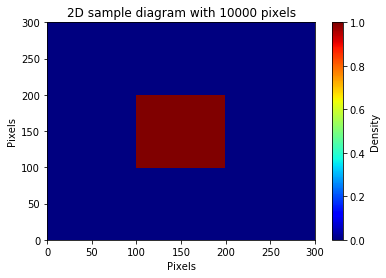

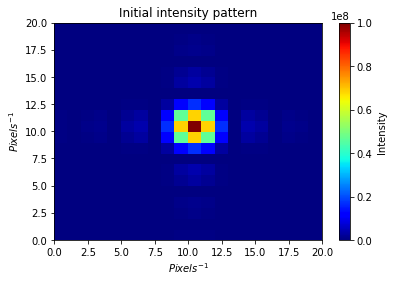

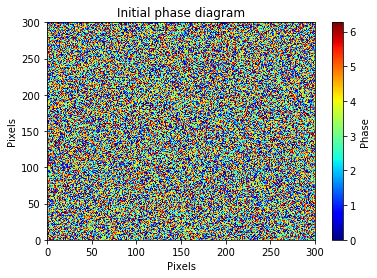

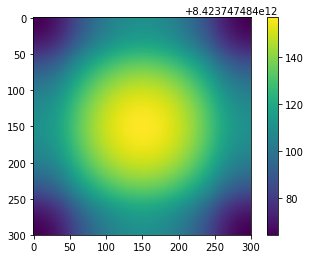

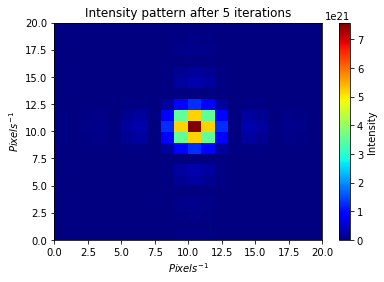

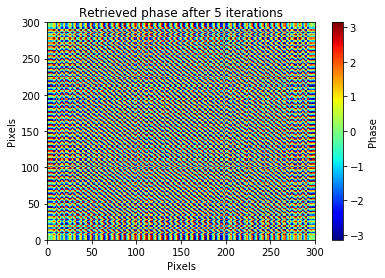

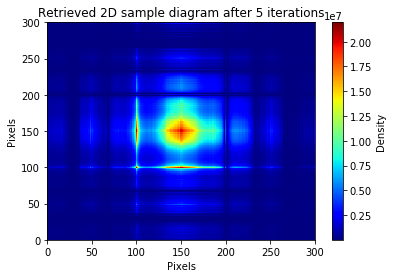

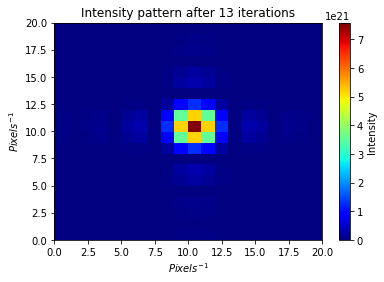

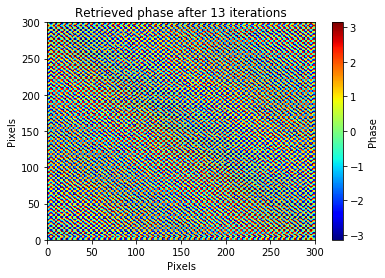

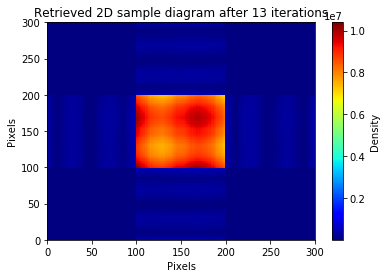

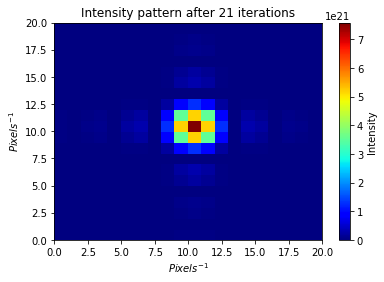

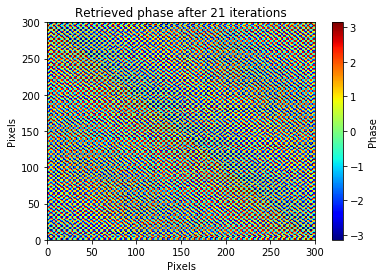

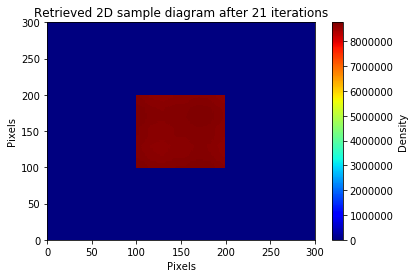

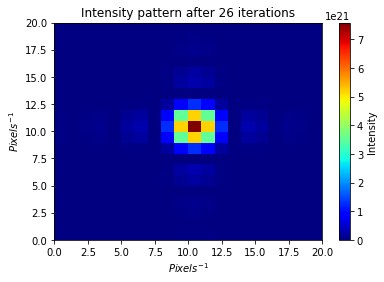

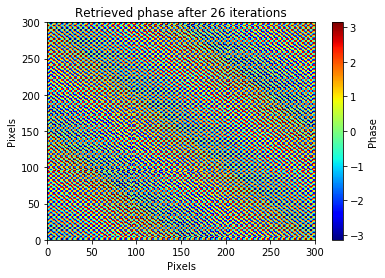

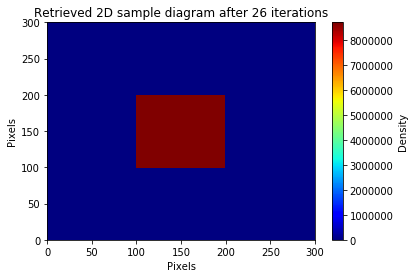

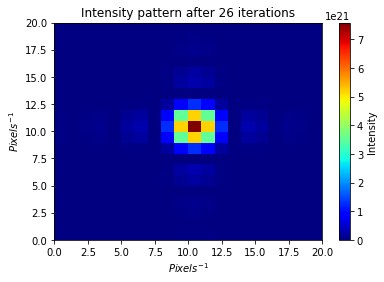

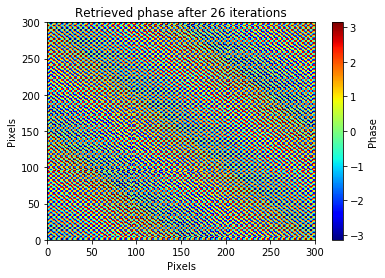

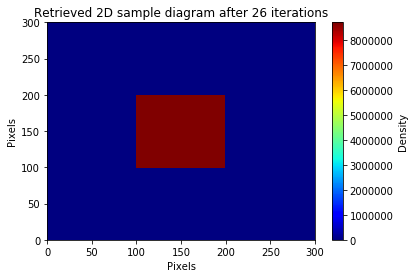

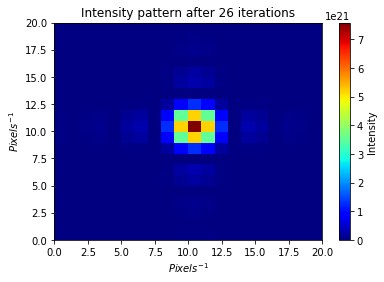

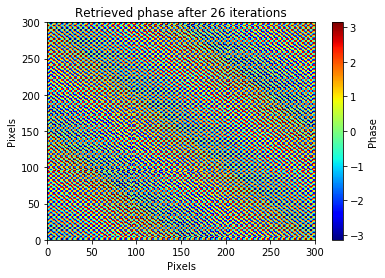

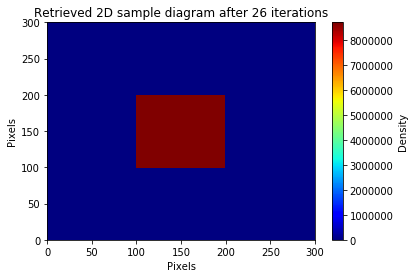

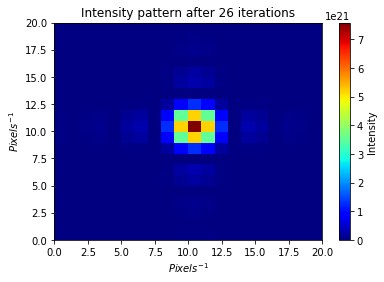

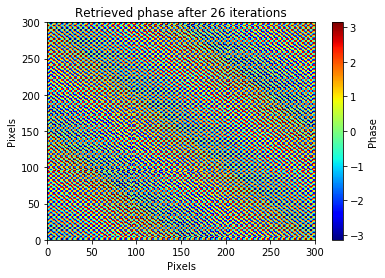

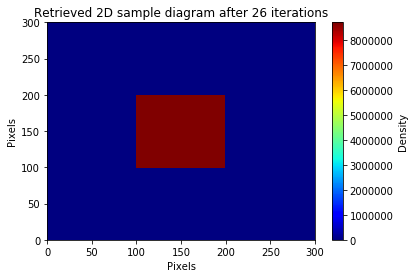

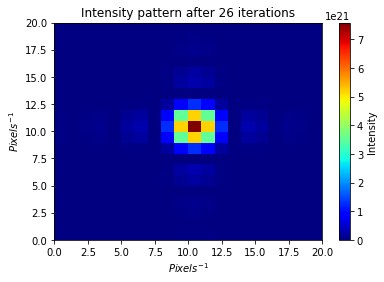

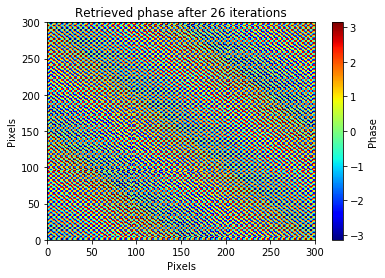

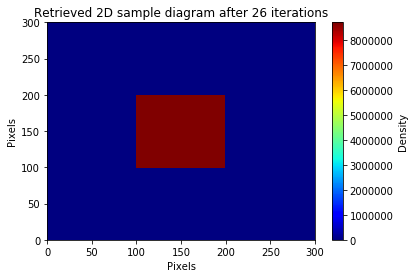

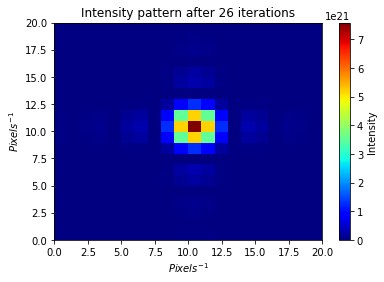

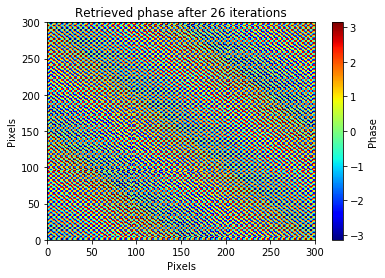

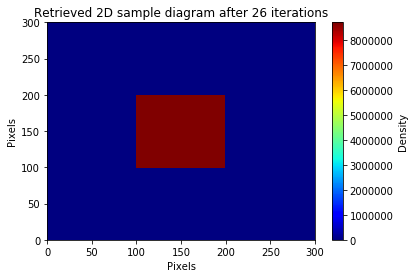

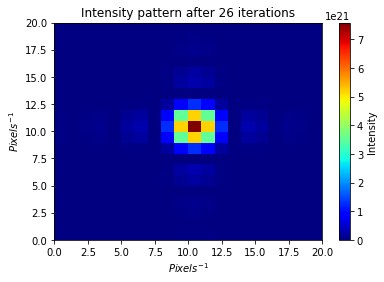

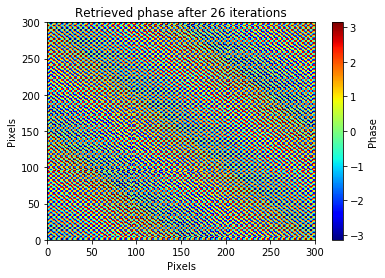

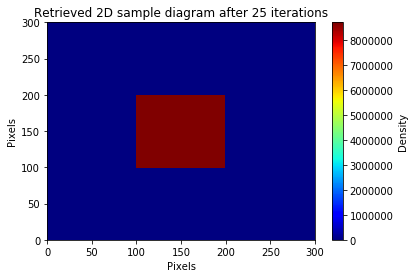

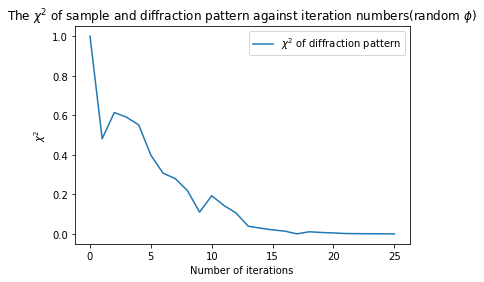

In [12]:
data=100,1e-6,1e-6,150,8000,8
phase_retrieval(data[0],data[1],data[2],data[3],data[4],data[5])

#N,L,a0,sigma_x_t,sigma_y_t,xi_l,L1,E,iters
#q[0],q[1],q[2],q[3],q[4],4.34e-4,2.19e-7,150,8000,100,1e-20,1,1